# ReadMe

## High Level Analysis of Tesla customer's review

# 1. Required libraries

In [23]:
import re
import ast
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
from nltk import pos_tag
# Download nltk resources (run once if needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jmlb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jmlb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jmlb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Utilities

In [44]:
def filter_adjectives(word_list):
    # Function to filter out adjectives
    # Tag each word with its part of speech
    pos_tags = pos_tag(word_list)
    
    # Filter out words that are tagged as adjectives (JJ, JJR, JJS)
    filtered_words = [word for word, tag in pos_tags if not tag.startswith('J')]
    
    return filtered_words


def filter_adverbs(word_list):
    # Function to filter out adverbs
    pos_tags = pos_tag(word_list)
    
    # Filter out words that are tagged as adverbs (RB, RBR, RBS)
    filtered_words = [word for word, tag in pos_tags if not tag.startswith('R')]
    
    return filtered_words


def filter_modals_aux_verbs(word_list):
    # Function to filter out modal and auxiliary verbs
    pos_tags = pos_tag(word_list)
    
    # Filter out words that are modal verbs (MD) or auxiliary verbs (VB, VBD, VBG, VBN, VBP, VBZ)
    filtered_words = [word for word, tag in pos_tags if tag not in ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]
    
    return filtered_words


def filter_verbs(word_list):
    # Tag each word with its part of speech
    pos_tags = pos_tag(word_list)
    
    # Filter out words that are tagged as verbs (VB, VBD, VBG, etc.)
    filtered_words = [word for word, tag in pos_tags if not tag.startswith('V')]
    
    return filtered_words


# Function to filter out adjectives
def filter_adjectives(word_list):
    # Tag each word with its part of speech
    pos_tags = pos_tag(word_list)
    
    # Filter out words that are tagged as adjectives (JJ, JJR, JJS)
    filtered_words = [word for word, tag in pos_tags if not tag.startswith('J')]
    
    return filtered_words


def filter_custom(word_list):
    specials = ["car", "tesla"]
    return [x for x in word_list if x not in specials]

# 3. Load dataset

In [25]:
reviews = pd.read_csv("dataset/tesla_customer_review_with_structured_data.csv")

# Select the valid structured reviews and create a dataFrame where each columns is a field of the dict
reviews_struct = pd.DataFrame([ast.literal_eval(x) for x in reviews[reviews["valid_struct"]]["review_struct"].tolist()])

print("Reviews struct data shape: {reviews_struct.shape}\n")
print("Reviews struct columns: {reviews_struct.columns}\n")

reviews_struct.head(5)


Reviews struct data shape: {reviews_struct.shape}

Reviews struct columns: {reviews_struct.columns}



,date_of_review,vehicle_model,customer_rating,review_summary,technical_pros,other_pros,technical_issues,other_issues,service_experience,overall_experience
0,"Oct. 26, 2022",model Y,1,We put a deposit down back in December 2021 fo...,[],[],[Tesla didn't deliver anywhere close to their ...,[I will not consider a vehicle or speak highly...,poor,terrible
1,2019-12-20,model 3 SR+,2,I ordered a model 3 SR+ from Tesla's existing ...,[],[The salesman contacted me to let me know the ...,[Wheels have some damage on them],[Salesman didn't offer to fix the issue before...,average,poor
2,2024-03-06,,1,"Best car i have ever owned, worst service i ha...",[],[The cars are great.],[They try to weasel out of every warrenty clai...,[they force customers to accept a estimate and...,terrible,terrible
3,2022-08-15,Model 3,1,"Horrible customer service, vehicle quality, ro...",[],[],[The car died with 100% battery charge],"[Poor communication, No one called me, No ment...",terrible,terrible
4,2022-03-29,2013 Model S,1,"I loved my car, drove smoothly and quietly, bu...","[Smooth ride, Great fuel efficiency]",[],[High voltage battery died],[Battery didn't take any charge at all and nev...,poor,terrible


# 4. High Level Data Analysis

## 4.1 Actual Customer Ratings

In [35]:
def unify_rating(r):
    map_int2str_rating = {1: "terrible", 2: "average", 3: "good", 4: "very good", 5: "exceptional"}
    if isinstance(r, str):
        if r.isnumeric():
            r = map_int2str_rating.get(r, "unknown")
        r = r.lower()
    elif isinstance(r, int):
        r = map_int2str_rating.get(r, "unknown")
    elif isinstance(r, type(None)):
        r = "unknown"
    return r


stats_on_customer_rating = reviews_struct["customer_rating"].apply(lambda r: unify_rating(r))
stats_on_customer_rating = stats_on_customer_rating.value_counts().to_frame("count")
stats_on_customer_rating["pct"] = stats_on_customer_rating["count"] / stats_on_customer_rating["count"].sum() * 100

stats_on_customer_rating

,count,pct
terrible,353,44.069913
exceptional,223,27.840200
average,127,15.855181
good,43,5.368290
unknown,32,3.995006
very good,22,2.746567
excellent,1,0.124844


## 4.2 Overall experience rating inferred by the LLM

In [26]:
stats_on_overall_rating = reviews_struct["overall_experience"].value_counts().to_frame("count")
stats_on_overall_rating["pct"] = stats_on_overall_rating["count"] / stats_on_overall_rating["count"].sum() * 100

stats_on_overall_rating

,count,pct
terrible,437,56.901042
exceptional,179,23.307292
,50,6.510417
poor,46,5.989583
average,36,4.687500
good,16,2.083333
mixed,1,0.130208
one star for tesla its one to many,1,0.130208
2 stars not 1,1,0.130208
exhilirating,1,0.130208


## 4.3 Alignment LLM vs. SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jmlb/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


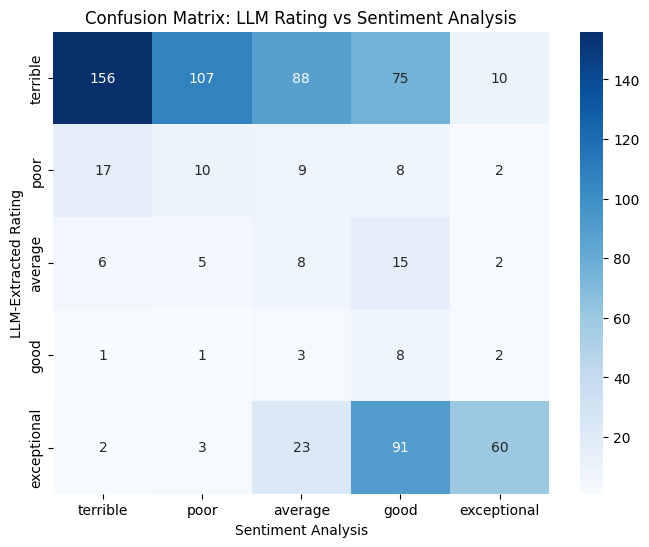

In [72]:
import nltk
import seaborn as sns
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


# Categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.8:
        return 'exceptional'
    elif score >= 0.2:
        return 'good'
    elif score >= -0.2:
        return 'average'
    elif score >= -0.5:
        return 'poor'
    else:
        return 'terrible'


# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get the sentiment score
def get_sentiment_score(r):
    score = sia.polarity_scores(r["review_summary"])
    r["sentiment_score"] = score["compound"]
    return r

subset = reviews_struct[["review_summary", "customer_rating", "overall_experience"]]
subset = subset.apply(lambda r: get_sentiment_score(r), axis=1)

# Apply sentiment category based on score
subset['sentiment_category'] = subset['sentiment_score'].apply(categorize_sentiment)

from sklearn.metrics import confusion_matrix

subset = subset.dropna()
# Generate a confusion matrix
conf_matrix = confusion_matrix(subset["overall_experience"], subset['sentiment_category'], labels=['terrible', 'poor', 'average', 'good', 'exceptional'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['terrible', 'poor', 'average', 'good', 'exceptional'], 
            yticklabels=['terrible', 'poor', 'average', 'good', 'exceptional'])
plt.xlabel("Sentiment Analysis")
plt.ylabel("LLM-Extracted Rating")
plt.title("Confusion Matrix: LLM Rating vs Sentiment Analysis")
plt.show()

In [85]:
# Example of dramatic discrepancy between LLM sentiment and nltk-based 

exple1 = subset[((subset.overall_experience == "terrible") & (subset.sentiment_category == "exceptional"))].iloc[1]
print(f"Sentiment score {exple1['sentiment_score']}({exple2['sentiment_category']}):\n{exple1['review_summary']}")
print()
exple2 = subset[((subset.overall_experience == "terrible") & (subset.sentiment_category == "exceptional"))].iloc[2]
print(f"Sentiment score {exple2['sentiment_score']}({exple2['sentiment_category']}):\n{exple2['review_summary']}")
print()
exple3 = subset[((subset.overall_experience == "terrible") & (subset.sentiment_category == "exceptional"))].iloc[5]
print(f"Sentiment score {exple3['sentiment_score']}({exple2['sentiment_category']}):\n{exple3['review_summary']}")

Sentiment score 0.9413(exceptional):
As far car is good, but as customer service are can’t be worse than Tesla for sure. I own 2 Tesla. I just ordered one more for my friend and I suppose to get 10000 credit, now they say I can’t get credit because I order it for him. I wish I never bought Tesla.

Sentiment score 0.8564(exceptional):
WOW, talk about going down hill! First off I will say that I was a huge Tesla Fan and have owned two Model S'\u0027s and I have six figures invested in Tesla stock (as of today, not so much tomorrow).

Sentiment score 0.9011(exceptional):
There is an initial thrill when you create an order online, but if you have any need to communicate, you are out of luck, Tesla is not set up for that. I can say with great certainty, Tesla Sales is understaffed, poorly trained and provide among the lowest customer service in both the automotive and Solar industries.


## 4.3 WordCloud of Technical Pros in customer reviews

Top20 words:
 [('fuel', 83), ('efficiency', 83), ('ride', 81), ('car', 21), ('performance', 9), ('acceleration', 9), ('technology', 9), ('drive', 8), ('software', 8), ('feature', 8), ('autopilot', 6), ('fun', 6), ('smooth', 5), ('network', 4), ('maintenance', 4), ('fast', 4), ('system', 4), ('design', 3), ('flawless', 3), ('road', 3), ('tech', 3), ('auto', 3), ('safest', 3), ('vehicle', 3), ('mode', 3), ('safety', 3), ('super', 3), ('none', 3), ('range', 3), ('time', 2)]


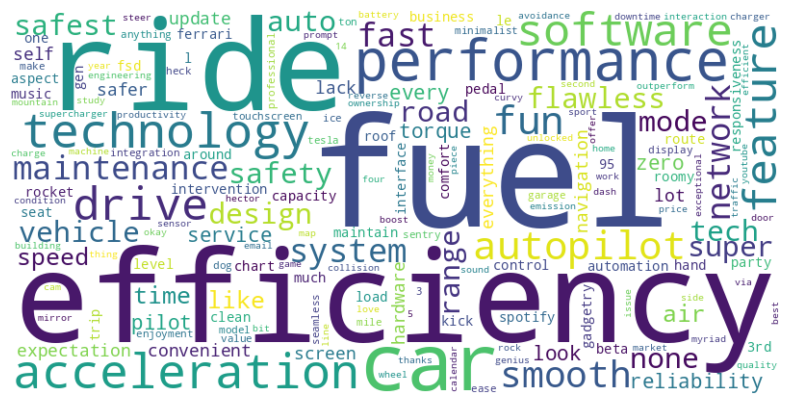

In [40]:
technical_pros = [x.strip().lower() for sublist in reviews_struct["technical_pros"].tolist() for x in sublist if len(x.strip()) > 1 and not x.strip().isnumeric()]
technical_pros = " ".join(technical_pros)

####################################
# Preprocessing
####################################
# 1. Tokenize the text
tokens = word_tokenize(technical_pros)

# 2. Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]

# 3. Lemmatization to get base form of the words
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

# 4. filter out adjectives, adverbs, verbs 
lemmatized_words = filter_adjectives(lemmatized_words)
lemmatized_words = filter_adverbs(lemmatized_words)
lemmatized_words = filter_modals_aux_verbs(lemmatized_words)

################################
# words count and wordcloud
################################
word_counts = Counter(lemmatized_words)
print("Top20 words:\n",  word_counts.most_common(30))

# Count word frequencies
word_frequencies = Counter(word_counts)

# Generate the word cloud from the frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4.4 WordCloud of Technical Issues in customer reviews

Top20 words:
 [('fuel', 83), ('efficiency', 83), ('ride', 81), ('performance', 9), ('acceleration', 9), ('technology', 9), ('drive', 8), ('software', 8), ('feature', 8), ('autopilot', 6), ('fun', 6), ('smooth', 5), ('network', 4), ('maintenance', 4), ('fast', 4), ('system', 4), ('design', 3), ('flawless', 3), ('road', 3), ('tech', 3), ('auto', 3), ('safest', 3), ('vehicle', 3), ('mode', 3), ('safety', 3), ('super', 3), ('none', 3), ('range', 3), ('time', 2), ('speed', 2)]


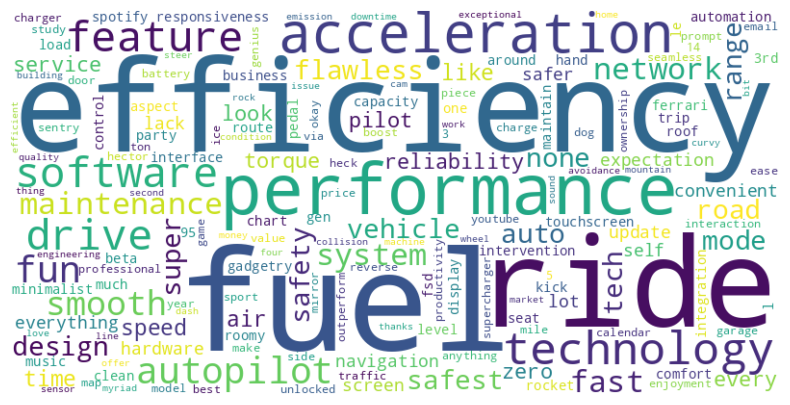

In [45]:
technical_cons = [x.strip().lower() for sublist in reviews_struct["technical_issues"].tolist() for x in sublist if len(x.strip()) > 1 and not x.strip().isnumeric()]
technical_cons = " ".join(technical_cons)

# 2. Tokenize the text
tokens = word_tokenize(technical_cons)

# 3. Remove stop words
stop_words = set(stopwords.words('english'))


####################################
# Preprocessing
####################################
# 1. Tokenize the text
tokens = word_tokenize(technical_pros)

# 2. Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]

# 3. Lemmatization to get base form of the words
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

# 4. filter out adjectives, adverbs, verbs 
lemmatized_words = filter_adjectives(lemmatized_words)
lemmatized_words = filter_adverbs(lemmatized_words)
lemmatized_words = filter_modals_aux_verbs(lemmatized_words)
lemmatized_words = filter_custom(lemmatized_words, ["car", "tesla"])

# 5. Extract most common words (optionally you can use POS tagging to filter for specific parts of speech)
word_counts = Counter(lemmatized_words)

################################
# words count and wordcloud
################################
word_counts = Counter(lemmatized_words)
print("Top20 words:\n",  word_counts.most_common(30))

# Count word frequencies
word_frequencies = Counter(word_counts)

# Generate the word cloud from the frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()